In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from collections import Counter
import xgboost as xgb
import tensorflow as tf
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras import Sequential
import joblib

In [3]:
#!pip install tf-nightly

     |████████████████████████████████| 467.2MB 24kB/s 
     |████████████████████████████████| 460kB 40.5MB/s 
     |████████████████████████████████| 2.9MB 48.1MB/s 
     |████████████████████████████████| 3.9MB 42.9MB/s 
     |████████████████████████████████| 81kB 8.0MB/s 
ERROR: tensorflow 1.15.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.11.0 which is incompatible.
ERROR: tb-nightly 2.2.0a20200207 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
  Found existing installation: h5py 2.8.0
    Uninstalling h5py-2.8.0:
      Successfully uninstalled h5py-2.8.0
  Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2


In [2]:
print(tf.__version__)

2.2.0-dev20200207


In [0]:
Data = pd.read_csv('/content/diabetes.csv')

data = Data.copy(deep=True)


## Data Decription:

1.   Pregnancies: Number of times pregnant
2.   Glucose: Plasma glucose concentration over 2 hours in an oral glucose tolerance test - milligrams per deciliter (mg/dL) Normal report around 200 mg/dL 
3. BloodPressure: Diastolic blood pressure (mm Hg)
4. SkinThickness: Triceps skin fold thickness (mm) (an indicator of bodyfat)
5. Insulin: 2-Hour serum insulin (mu U/ml)
6. BMI: Body mass index (weight in kg/(height in m)2)
7. DiabetesPedigreeFunction: Diabetes pedigree function (a function which scores likelihood of diabetes based on family history)
8. Age: Age (years)
9. Outcome: Class variable (0 if non-diabetic, 1 if diabetic)

    
    
    
    
   
    
    


In [4]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
# No null values
data.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [7]:
# No duplicate values
data.duplicated().sum()

0

In [8]:
# Descriptive Statistics: 
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [0]:
# replace the values of 0 with median value as Insulin has many outliers as the mean - median value is very high
m = data.Insulin == 0

data['Insulin'] = data.where(~m,other=(data['Insulin'].median()))

In [10]:
data['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [11]:
data.shape

(768, 9)

In [12]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [13]:
# As we can see the Data we have is pretty imbalanced. Records which dont have diabetes are 500 where Records which have diabetes are only 268. 
# Training our model with such imbalanced data will make our model OVERFIT. 

# To make our data Balanced, we try to generate synthetic data. This is done by ADASYN Algorithm.

X = data.iloc[:,:-1].values
y = data.iloc[:,-1].values

print('Shape of Feature Matrix:', X.shape)
print('Shape of Target Vector:', y.shape)

print('Original Target Variable Distribution:', Counter(y))

ada = ADASYN(sampling_strategy='minority', random_state= 420 , n_neighbors = 5)

Features, Target = ada.fit_resample(X,y)

print('Oversampled Target Variable Distribution:', Counter(Target))

df = pd.DataFrame.from_records(Features, columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age'])
df['Outcome'] = Target

data = df.copy(deep=True)

Shape of Feature Matrix: (768, 8)
Shape of Target Vector: (768,)
Original Target Variable Distribution: Counter({0: 500, 1: 268})
Oversampled Target Variable Distribution: Counter({1: 510, 0: 500})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [14]:
data.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.105922,0.120608,-0.088824,0.297345,-0.011941,-0.034372,0.528449,0.219030
Glucose,0.105922,1.000000,0.158168,0.030086,-0.034006,0.188589,0.100663,0.243490,0.373173
BloodPressure,0.120608,0.158168,1.000000,0.194266,-0.050579,0.288822,0.046839,0.250801,0.082815
SkinThickness,-0.088824,0.030086,0.194266,1.000000,-0.560097,0.399195,0.208615,-0.131278,0.068050
Insulin,0.297345,-0.034006,-0.050579,-0.560097,1.000000,-0.151094,-0.173656,0.288429,0.072090
BMI,-0.011941,0.188589,0.288822,0.399195,-0.151094,1.000000,0.153432,0.000612,0.284218
DiabetesPedigreeFunction,-0.034372,0.100663,0.046839,0.208615,-0.173656,0.153432,1.000000,0.002055,0.184596
Age,0.528449,0.243490,0.250801,-0.131278,0.288429,0.000612,0.002055,1.000000,0.226492
Outcome,0.219030,0.373173,0.082815,0.068050,0.072090,0.284218,0.184596,0.226492,1.000000


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 9 columns):
Pregnancies                 1010 non-null float64
Glucose                     1010 non-null float64
BloodPressure               1010 non-null float64
SkinThickness               1010 non-null float64
Insulin                     1010 non-null float64
BMI                         1010 non-null float64
DiabetesPedigreeFunction    1010 non-null float64
Age                         1010 non-null float64
Outcome                     1010 non-null int64
dtypes: float64(8), int64(1)
memory usage: 71.1 KB


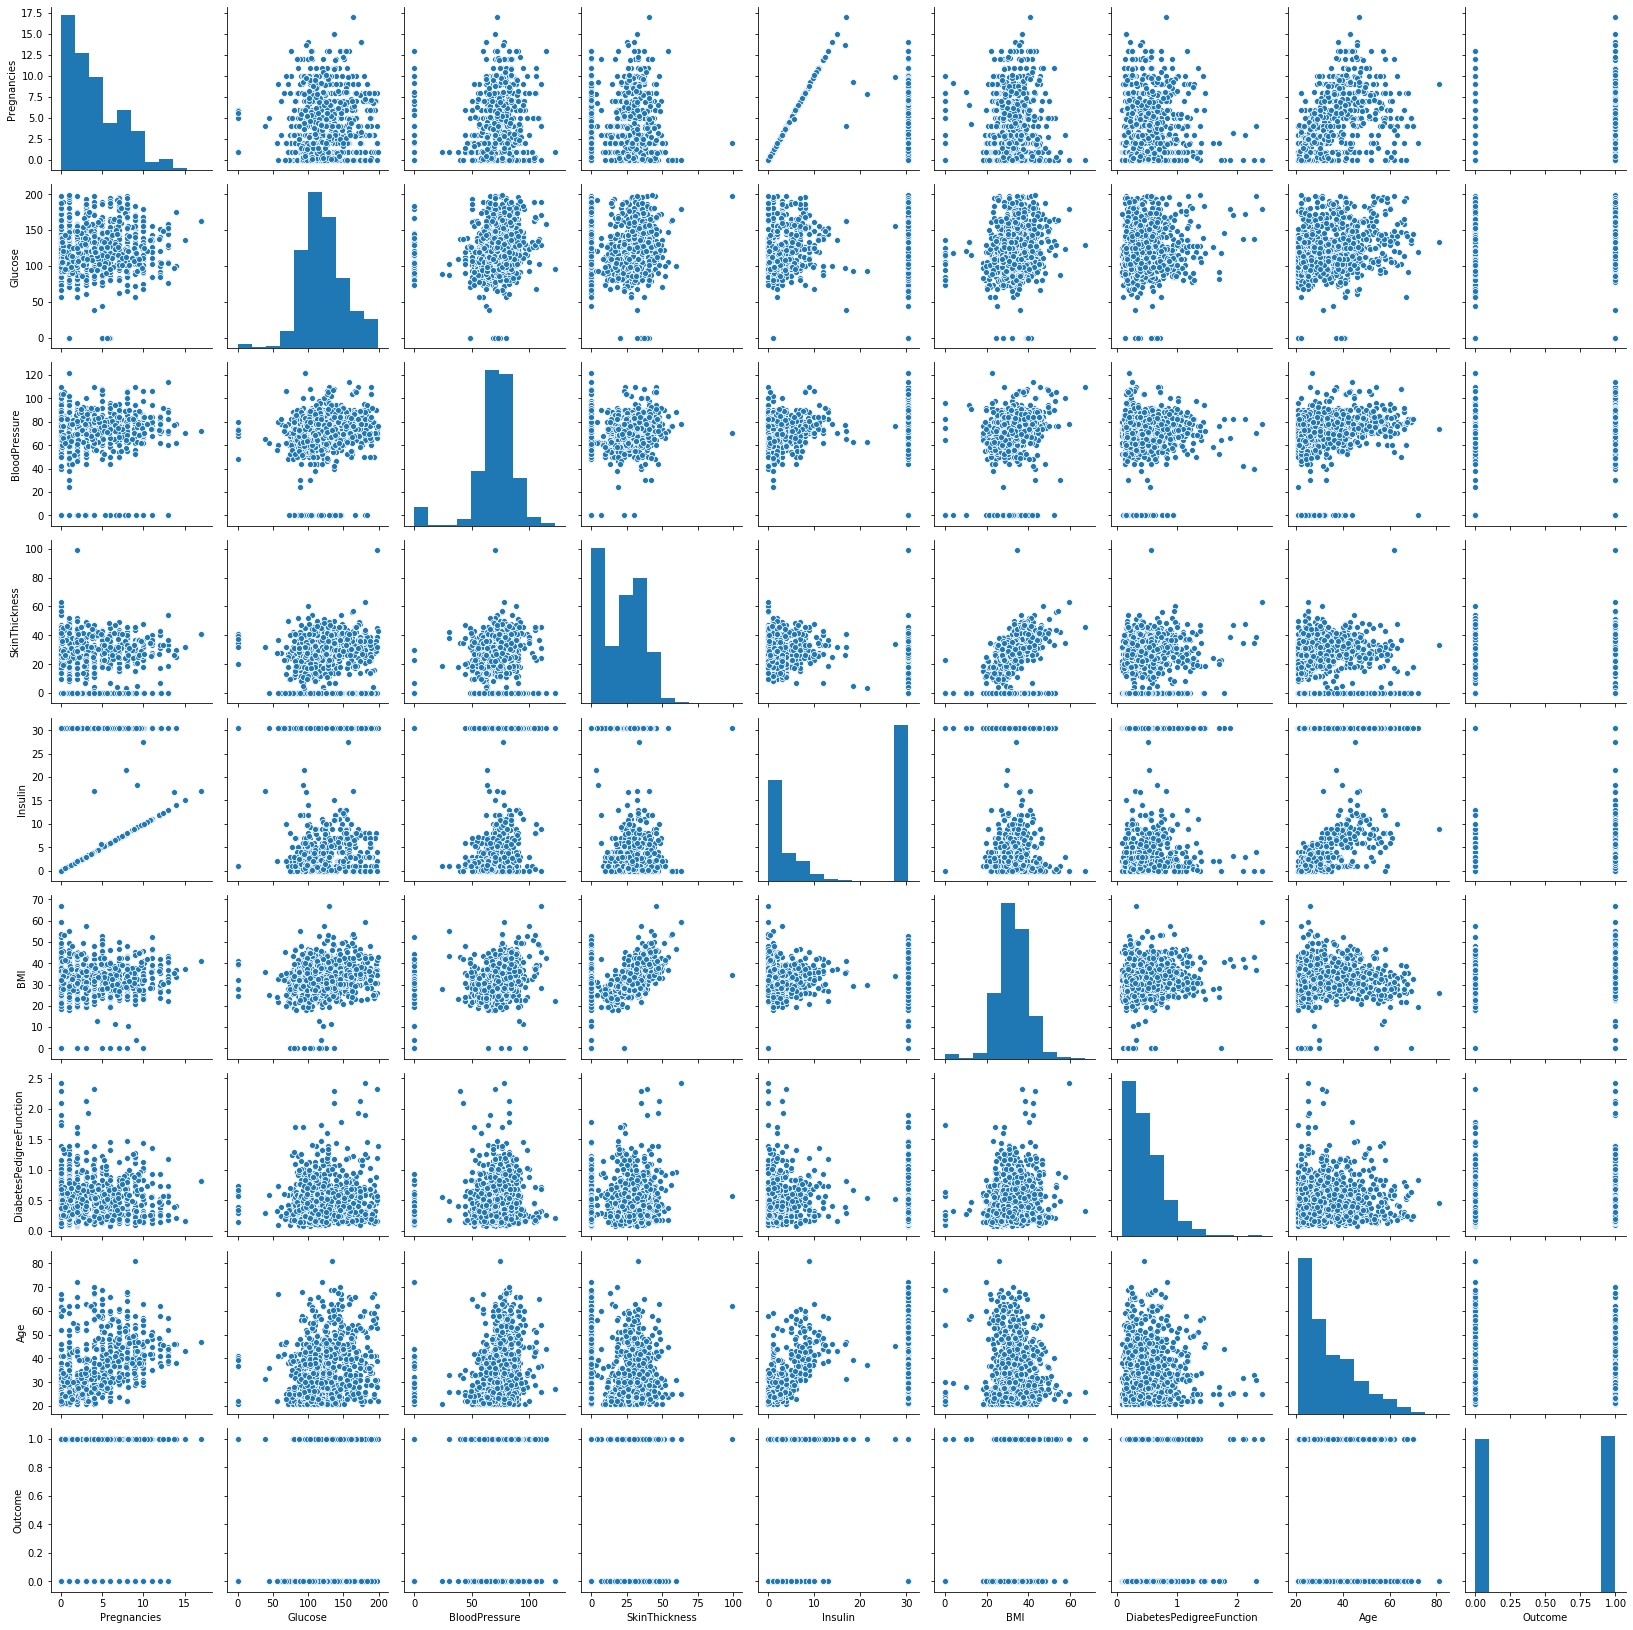

In [20]:
# To understand the relationship between many features
sns.pairplot(data)

                          Pregnancies   Glucose  ...       Age   Outcome
Pregnancies                  1.000000  0.105922  ...  0.528449  0.219030
Glucose                      0.105922  1.000000  ...  0.243490  0.373173
BloodPressure                0.120608  0.158168  ...  0.250801  0.082815
SkinThickness               -0.088824  0.030086  ... -0.131278  0.068050
Insulin                      0.297345 -0.034006  ...  0.288429  0.072090
BMI                         -0.011941  0.188589  ...  0.000612  0.284218
DiabetesPedigreeFunction    -0.034372  0.100663  ...  0.002055  0.184596
Age                          0.528449  0.243490  ...  1.000000  0.226492
Outcome                      0.219030  0.373173  ...  0.226492  1.000000

[9 rows x 9 columns]


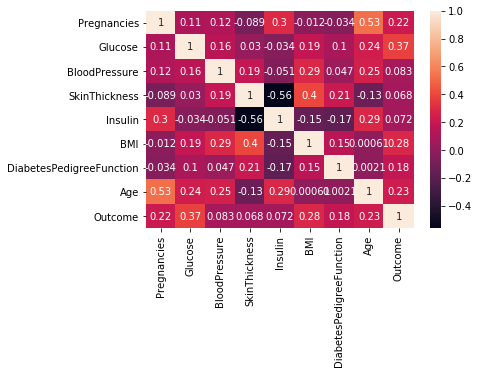

In [165]:
# A better way to understand the relationships is using a heat map.
corr = data.corr()
print(corr)
sns.heatmap(corr, 
         xticklabels=corr.columns, 
         yticklabels=corr.columns,
         annot=True)

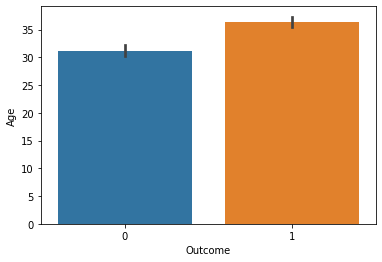

In [48]:
sns.barplot(data=data, x='Outcome',y='Age')

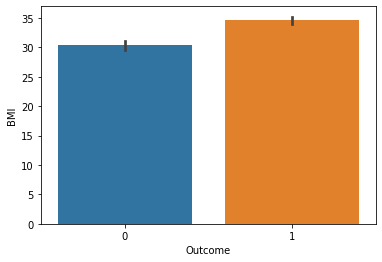

In [49]:
sns.barplot(data=data, x='Outcome',y='BMI')

In [50]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000
mean,4.029092,121.600764,69.756669,20.764855,16.822117,32.467463,0.490017,33.811765,0.504950
std,3.306613,30.848880,18.812303,16.025802,13.715772,7.540015,0.323512,11.467161,0.500223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,101.000000,64.000000,0.000000,2.000000,28.113400,0.255273,24.493784,0.000000
50%,3.000000,119.000000,72.000000,24.000000,13.500000,32.603644,0.407500,30.207951,1.000000
75%,6.000000,139.000000,80.000000,33.000000,30.500000,36.539994,0.648296,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,30.500000,67.100000,2.420000,81.000000,1.000000


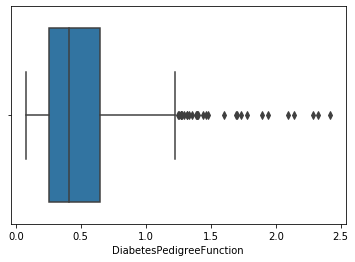

In [51]:
sns.boxplot('DiabetesPedigreeFunction', data=data)

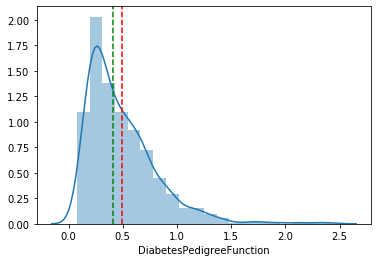

In [52]:
mean = data['DiabetesPedigreeFunction'].mean()
median = data['DiabetesPedigreeFunction'].median()

f, ax_hist = plt.subplots(1)

# sns.distplot(data['Insulin'], bins=20, ax=ax_hist)
sns.distplot(data['DiabetesPedigreeFunction'], bins=20, ax=ax_hist)

plt.axvline(mean, color='r', linestyle='--')
plt.axvline(median, color='g', linestyle='--')

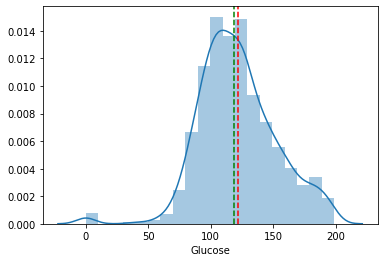

In [53]:
# mean = data['Insulin'].mean()
# median = data['Insulin'].median()

mean = data['Glucose'].mean()
median = data['Glucose'].median()


f, ax_hist = plt.subplots(1)

# sns.distplot(data['Insulin'], bins=20, ax=ax_hist)
sns.distplot(data['Glucose'], bins=20, ax=ax_hist)

plt.axvline(mean, color='r', linestyle='--')
plt.axvline(median, color='g', linestyle='--')

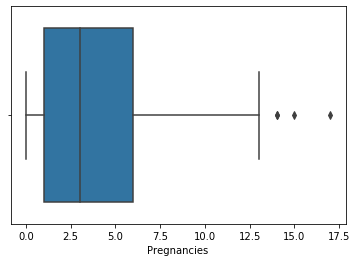

In [0]:
# plotting Multiple Box plots to understand the IQR and detect outliers:

sns.boxplot(data['Pregnancies'])
# sns.boxplot(data['Glucose'])
# sns.boxplot(data['BloodPressure'])
# sns.boxplot(data['SkinThickness'])
# sns.boxplot(data['Insulin'])
# sns.boxplot(data['BMI'])
# sns.boxplot(data['DiabetesPedigreeFunction'])
# sns.boxplot(data['Age'])


In [0]:
# Splitting the data into 80% train data and 20% test data

train,test = train_test_split(data, random_state=42, test_size=0.2)

In [17]:
train.shape

(808, 9)

In [0]:
train_x = train.drop('Outcome', axis=1) 
train_y = train['Outcome']

In [0]:
test_x = test.drop('Outcome', axis=1) 
test_y = test['Outcome']

In [0]:
# Data Standardization:

Stdscalar = StandardScaler()

train_x = Stdscalar.fit_transform(train_x)
test_x = Stdscalar.fit_transform(test_x)

##Naive Bayes Model:

In [21]:
nb_m = GaussianNB()

nb_m.fit(train_x,train_y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [0]:
prediction_train = nb_m.predict(train_x)

accuracy_train = accuracy_score(train_y, prediction_train)

precision_train = precision_score(train_y, prediction_train)

recall_train = recall_score(train_y, prediction_train)

In [23]:
print('Naive Bayes: ')
print('Accuracy over Training set: {}'.format(accuracy_train))

Naive Bayes: 
Accuracy over Training set: 0.7054455445544554


In [24]:
f1_train = f1_score(train_y, prediction_train)

confusion_matrix_train = confusion_matrix(train_y, prediction_train) 

print('F1 score over Training set: {}'.format(f1_train))

print('Precision over Training set: {}'.format(precision_train))

print('Recall rate over Training set: {}'.format(recall_train))

print('Confusion Matrix over Training set: {}'.format(confusion_matrix_train))

F1 score over Training set: 0.7054455445544555
Precision over Training set: 0.7160804020100503
Recall rate over Training set: 0.6951219512195121
Confusion Matrix over Training set: [[285 113]
 [125 285]]


In [0]:
y_probaNB = cross_val_predict( nb_m, train_x, train_y, cv=3, method="predict_proba")
y_scores_nb = y_probaNB[:,1] 
fpr_nb, tpr_nb, threshold_nb = roc_curve(train_y, y_scores_nb)
roc_auc_score_nb = roc_auc_score(train_y, y_scores_nb)

ROC AUC SCORE over the Training set is found to be 0.774.

In [26]:
roc_auc_score_nb

0.7744882951342076

## Logistic Regression Model

In [0]:
lr_m = LogisticRegression()

In [28]:
lr_m.fit(train_x,train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
prediction_train = lr_m.predict(train_x)

accuracy_train = accuracy_score(train_y, prediction_train)

precision_train = precision_score(train_y, prediction_train)

recall_train = recall_score(train_y, prediction_train)

In [30]:
print('Logistic Regression: ')
print('Accuracy over Training set: {}'.format(accuracy_train))

Logistic Regression: 
Accuracy over Training set: 0.7178217821782178


In [31]:
f1_train = f1_score(train_y, prediction_train)

confusion_matrix_train = confusion_matrix(train_y, prediction_train) 

print('F1 score over Training set: {}'.format(f1_train))

print('Precision over Training set: {}'.format(precision_train))

print('Recall rate over Training set: {}'.format(recall_train))

print('Confusion Matrix over Training set: {}'.format(confusion_matrix_train))

F1 score over Training set: 0.7219512195121951
Precision over Training set: 0.7219512195121951
Recall rate over Training set: 0.7219512195121951
Confusion Matrix over Training set: [[284 114]
 [114 296]]


In [0]:
y_probaLR = cross_val_predict( lr_m, train_x, train_y, cv=3, method="predict_proba")
y_scores_lr = y_probaLR[:,1] 
fpr_lr, tpr_lr, threshold_lr = roc_curve(train_y, y_scores_lr)
roc_auc_score_lr = roc_auc_score(train_y, y_scores_lr)

ROC AUC SCORE over the Training set is found to be 0.78.

In [33]:
roc_auc_score_lr

0.7833435470033092

Text(0.5, 0, 'Importance')

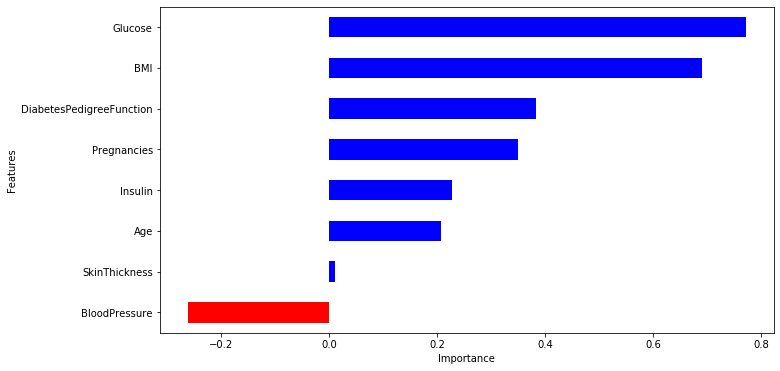

In [34]:
# Check out the Important features which contribute alot to our prediction:

coeff = list(lr_m.coef_[0])
labels = list(train.drop('Outcome', axis=1).columns)
features = pd.DataFrame()
features['Features'] = labels
features['importance'] = coeff
features.sort_values(by=['importance'], ascending=True, inplace=True)
features['positive'] = features['importance'] > 0
features.set_index('Features', inplace=True)
features.importance.plot(kind='barh', figsize=(11, 6),color = features.positive.map({True: 'blue', False: 'red'}))
plt.xlabel('Importance')

In [35]:
# Saving the Model:

joblib.dump(lr_m,'LR_model.pkl')

['LR_model.pkl']

##From the above figure, we can draw the following conclusions.

1.Glucose level, BMI, pregnancies and diabetes pedigree function have significant influence on the model, specially glucose level and BMI. It is good to see our machine learning model match what we have been hearing from doctors our entire lives!

2.Blood pressure has a negative influence on the prediction, i.e. higher blood pressure is correlated with a person not being diabetic. (also, note that blood pressure is more important as a feature than age, because the magnitude is higher for blood pressure).
    
3.Although age was more correlated than BMI to the output variables (as we saw during data exploration), the model relies more on BMI. This can happen for several reasons, including the fact that the correlation captured by age is also captured by some other variable, whereas the information captured by BMI is not captured by other variables.

## KNN Classifier Model

In [0]:
knn_m = KNeighborsClassifier(n_neighbors=3)

In [37]:
knn_m.fit(train_x, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [0]:
prediction_train = knn_m.predict(train_x)

accuracy_train = accuracy_score(train_y, prediction_train)

precision_train = precision_score(train_y, prediction_train)

recall_train = recall_score(train_y, prediction_train)

In [39]:
print('KNN Classifier: ')
print('Accuracy over Training set: {}'.format(accuracy_train))

KNN Classifier: 
Accuracy over Training set: 0.8811881188118812


In [40]:
f1_train = f1_score(train_y, prediction_train)

confusion_matrix_train = confusion_matrix(train_y, prediction_train) 

print('F1 score over Training set: {}'.format(f1_train))

print('Precision over Training set: {}'.format(precision_train))

print('Recall rate over Training set: {}'.format(recall_train))

print('Confusion Matrix over Training set: {}'.format(confusion_matrix_train))

F1 score over Training set: 0.8921348314606741
Precision over Training set: 0.8270833333333333
Recall rate over Training set: 0.9682926829268292
Confusion Matrix over Training set: [[315  83]
 [ 13 397]]


In [0]:
y_probaKNN = cross_val_predict( knn_m, train_x, train_y, cv=3, method="predict_proba")
y_scores_knn = y_probaKNN[:,1] 
fpr_knn, tpr_knn, threshold_knn = roc_curve(train_y, y_scores_knn)
roc_auc_score_knn = roc_auc_score(train_y, y_scores_knn)

ROC AUC SCORE over the Training set is found to be 0.762.

In [42]:
roc_auc_score_knn

0.7624647628385832

##SGD Classifier Model

In [0]:
sgd_m = SGDClassifier(random_state=42)

In [44]:
sgd_m.fit(train_x, train_y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
prediction_train = sgd_m.predict(train_x)

accuracy_train = accuracy_score(train_y, prediction_train)

precision_train = precision_score(train_y, prediction_train)

recall_train = recall_score(train_y, prediction_train)

In [46]:
print('SGD Classifier: ')
print('Accuracy over Training set: {}'.format(accuracy_train))

SGD Classifier: 
Accuracy over Training set: 0.6707920792079208


In [47]:
f1_train = f1_score(train_y, prediction_train)

confusion_matrix_train = confusion_matrix(train_y, prediction_train) 

print('SGD Classifier: ')

print('F1 score over Training set: {}'.format(f1_train))

print('Precision over Training set: {}'.format(precision_train))

print('Recall rate over Training set: {}'.format(recall_train))

print('Confusion Matrix over Training set: {}'.format(confusion_matrix_train))

SGD Classifier: 
F1 score over Training set: 0.6942528735632184
Precision over Training set: 0.6565217391304348
Recall rate over Training set: 0.7365853658536585
Confusion Matrix over Training set: [[240 158]
 [108 302]]


In [0]:
y_scores_sgdC = sgd_m.decision_function(train_x)

In [0]:
roc_auc_sgdC = roc_auc_score(train_y, y_scores_sgdC)

ROC AUC SCORE over the Training set is found to be 0.748.

In [50]:
roc_auc_sgdC

0.7482412060301508

## Random Forest CLassifier Model

In [0]:
model = RandomForestClassifier()

In [52]:
model.fit(train_x,train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
prediction_train = model.predict(train_x)

accuracy_train = accuracy_score(train_y, prediction_train)

precision_train = precision_score(train_y, prediction_train)

recall_train = recall_score(train_y, prediction_train)

In [54]:
print('Random Forest Classifier: ')
print('Accuracy over Training set: {}'.format(accuracy_train))

Random Forest Classifier: 
Accuracy over Training set: 1.0


In [55]:
f1_train = f1_score(train_y, prediction_train)

confusion_matrix_train = confusion_matrix(train_y, prediction_train) 

print('F1 score over Training set: {}'.format(f1_train))

print('Precision over Training set: {}'.format(precision_train))

print('Recall rate over Training set: {}'.format(recall_train))

print('Confusion Matrix over Training set: {}'.format(confusion_matrix_train))

F1 score over Training set: 1.0
Precision over Training set: 1.0
Recall rate over Training set: 1.0
Confusion Matrix over Training set: [[398   0]
 [  0 410]]


In [0]:
y_probaForest = cross_val_predict( model, train_x, train_y, cv=5, method="predict_proba")
y_scores_rf = y_probaForest[:,1] 
fpr_rf, tpr_rf, threshold_rf = roc_curve(train_y, y_scores_rf)
roc_auc_score_rf = roc_auc_score(train_y, y_scores_rf)

ROC AUC SCORE over the Training set is found to be 0.871.

In [57]:
roc_auc_score_rf

0.8711116558401765

After Grid Search :

In [0]:
param_grid = [
              {'n_estimators':[3,10,20,], 'max_features':[1,4,5,6,7]},
              {'bootstrap':[False],'n_estimators':[3,10], 'max_features':[1,4,5,6]}
]

In [59]:
grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='f1', return_train_score=True)
grid_search.fit(train_x,train_y)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [60]:
grid_search.best_params_

{'max_features': 4, 'n_estimators': 20}

In [0]:
cvres = grid_search.cv_results_

In [62]:
for f1_score, params in zip(cvres['mean_test_score'], cvres['params']):
  print(f1_score,params)

0.7461025529515 {'max_features': 1, 'n_estimators': 3}
0.7372051536071323 {'max_features': 1, 'n_estimators': 10}
0.7646888475370532 {'max_features': 1, 'n_estimators': 20}
0.7374540050715519 {'max_features': 4, 'n_estimators': 3}
0.7680334750741296 {'max_features': 4, 'n_estimators': 10}
0.7963513037350246 {'max_features': 4, 'n_estimators': 20}
0.7447710721779324 {'max_features': 5, 'n_estimators': 3}
0.7688109155613776 {'max_features': 5, 'n_estimators': 10}
0.7599797906872359 {'max_features': 5, 'n_estimators': 20}
0.7174554706593405 {'max_features': 6, 'n_estimators': 3}
0.7715095945413946 {'max_features': 6, 'n_estimators': 10}
0.7864977405847109 {'max_features': 6, 'n_estimators': 20}
0.7568129334529022 {'max_features': 7, 'n_estimators': 3}
0.7477561918983241 {'max_features': 7, 'n_estimators': 10}
0.7951762716921088 {'max_features': 7, 'n_estimators': 20}
0.763577841018498 {'bootstrap': False, 'max_features': 1, 'n_estimators': 3}
0.7878955971069291 {'bootstrap': False, 'max_f

In [63]:
final_model = grid_search.best_estimator_
final_predictions = final_model.predict(train_x)
accuracy_test = accuracy_score(train_y, final_predictions)

precision_test = precision_score(train_y, final_predictions)

recall_test = recall_score(train_y, final_predictions)
print('XG Boosting Classifier: ')
print('Accuracy over Test set: {}'.format(accuracy_train))

XG Boosting Classifier: 
Accuracy over Test set: 1.0


In [0]:
y_proba_rf = cross_val_predict( final_model, train_x, train_y, cv=5, method="predict_proba")
y_scores_rf = y_proba_rf[:,1] 
fpr_rf, tpr_rf, threshold_rf = roc_curve(train_y, y_scores_rf)
roc_auc_score_rf = roc_auc_score(train_y, y_scores_rf)

After Grid Search, ROC AUC SCORE over the Training set is found to be 0.85.

In [65]:
roc_auc_score_rf

0.8491941414389018

In [71]:
# Saving Model

joblib.dump(model, 'RF_Model.pkl')

['RF_Model.pkl']

## SVM Classifier Model

In [0]:
model = SVC()

In [81]:
model.fit(train_x, train_y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
prediction_train = model.predict(train_x)

accuracy_train = accuracy_score(train_y, prediction_train)

precision_train = precision_score(train_y, prediction_train)

recall_train = recall_score(train_y, prediction_train)

In [83]:
print('Support Vector Classifier: ')
print('Accuracy over Training set: {}'.format(accuracy_train))

Support Vector Classifier: 
Accuracy over Training set: 0.818069306930693


In [84]:
f1_train = f1_score(train_y, prediction_train)

confusion_matrix_train = confusion_matrix(train_y, prediction_train) 

print('F1 score over Training set: {}'.format(f1_train))

print('Precision over Training set: {}'.format(precision_train))

print('Recall rate over Training set: {}'.format(recall_train))

print('Confusion Matrix over Training set: {}'.format(confusion_matrix_train))

TypeError: ignored

In [0]:
y_probaSVC = cross_val_predict( model, train_x, train_y, cv=3, method="decision_function")
y_scores_svm = list(y_probaSVC)
fpr_svm, tpr_svm, threshold_svm = roc_curve(train_y, y_scores_svm)
roc_auc_score_svm = roc_auc_score(train_y, y_scores_svm)

ROC AUC SCORE over the Training set is found to be 0.817.

In [86]:
roc_auc_score_svm

0.8178943497977693

## Gradient Boosting Classifier Model

In [87]:
GB_classifier = GradientBoostingClassifier()
GB_classifier.fit(train_x,train_y)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [0]:
prediction_train = GB_classifier.predict(train_x)

accuracy_train = accuracy_score(train_y, prediction_train)

precision_train = precision_score(train_y, prediction_train)

recall_train = recall_score(train_y, prediction_train)

In [89]:
print('Gradiant Boosting Classifier: ')
print('Accuracy over Training set: {}'.format(accuracy_train))

Gradiant Boosting Classifier: 
Accuracy over Training set: 0.9183168316831684


In [90]:
f1_train = f1_score(train_y, prediction_train)

confusion_matrix_train = confusion_matrix(train_y, prediction_train) 

print('F1 score over Training set: {}'.format(f1_train))

print('Precision over Training set: {}'.format(precision_train))

print('Recall rate over Training set: {}'.format(recall_train))

print('Confusion Matrix over Training set: {}'.format(confusion_matrix_train))

TypeError: ignored

In [0]:
y_probaGBC = cross_val_predict( GB_classifier, train_x, train_y, cv=5, method="predict_proba")
y_scores_GBC = y_probaGBC[:,1] 
fpr_GBC, tpr_GBC, threshold_GBC = roc_curve(train_y, y_scores_GBC)
roc_auc_score_GBC = roc_auc_score(train_y, y_scores_GBC)

ROC AUC SCORE over the Training set is found to be 0.84.

In [92]:
roc_auc_score_GBC

0.8465988478980268

## XG Boost Classifier Model

In [93]:
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(train_x,train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
prediction_train = xgb_classifier.predict(train_x)

accuracy_train = accuracy_score(train_y, prediction_train)

precision_train = precision_score(train_y, prediction_train)

recall_train = recall_score(train_y, prediction_train)

In [95]:
print('XG Boosting Classifier: ')
print('Accuracy over Training set: {}'.format(accuracy_train))

XG Boosting Classifier: 
Accuracy over Training set: 0.8948019801980198


In [96]:
f1_train = f1_score(train_y, prediction_train)

confusion_matrix_train = confusion_matrix(train_y, prediction_train) 

print('F1 score over Training set: {}'.format(f1_train))

print('Precision over Training set: {}'.format(precision_train))

print('Recall rate over Training set: {}'.format(recall_train))

print('Confusion Matrix over Training set: {}'.format(confusion_matrix_train))

TypeError: ignored

In [0]:
y_probaXgGC = cross_val_predict( xgb_classifier, train_x, train_y, cv=5, method="predict_proba")
y_scores_XgGC = y_probaXgGC[:,1] 
fpr_XgGC, tpr_XgGC, threshold_XgGC = roc_curve(train_y, y_scores_XgGC)
roc_auc_score_XgGC = roc_auc_score(train_y, y_scores_XgGC)

ROC AUC SCORE over the Training set is found to be 0.84.

In [98]:
roc_auc_score_XgGC

0.8426706704252972

In [99]:
# Saving the Model:

joblib.dump(xgb_classifier,'XGBoost_model.pkl')

['XGBoost_model.pkl']

Applying Grid Search for some Hyperparameter tuning

In [0]:
param_grid = [
              {'n_estimators':[3,10,20,], 'max_features':[1,4,5,6,7]},
              {'bootstrap':[False],'n_estimators':[3,10], 'max_features':[1,4,5,6]}
]

In [0]:
grid_search = GridSearchCV(xgb_classifier, param_grid=param_grid, cv=5, scoring='f1', return_train_score=True)

In [102]:
grid_search.fit(train_x,train_y)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid=[{'max_features': [1, 4, 5, 6, 7],
                          'n_estimators': [3, 10, 20]},
                         {'bootstrap': [False], 'max_features'

In [103]:
grid_search.best_params_

{'max_features': 1, 'n_estimators': 20}

In [0]:
cvres = grid_search.cv_results_

In [105]:
for f1_score, params in zip(cvres['mean_test_score'], cvres['params']):
  print(f1_score,params)

0.7349793330520136 {'max_features': 1, 'n_estimators': 3}
0.7730663161067642 {'max_features': 1, 'n_estimators': 10}
0.7756466043314637 {'max_features': 1, 'n_estimators': 20}
0.7349793330520136 {'max_features': 4, 'n_estimators': 3}
0.7730663161067642 {'max_features': 4, 'n_estimators': 10}
0.7756466043314637 {'max_features': 4, 'n_estimators': 20}
0.7349793330520136 {'max_features': 5, 'n_estimators': 3}
0.7730663161067642 {'max_features': 5, 'n_estimators': 10}
0.7756466043314637 {'max_features': 5, 'n_estimators': 20}
0.7349793330520136 {'max_features': 6, 'n_estimators': 3}
0.7730663161067642 {'max_features': 6, 'n_estimators': 10}
0.7756466043314637 {'max_features': 6, 'n_estimators': 20}
0.7349793330520136 {'max_features': 7, 'n_estimators': 3}
0.7730663161067642 {'max_features': 7, 'n_estimators': 10}
0.7756466043314637 {'max_features': 7, 'n_estimators': 20}
0.7349793330520136 {'bootstrap': False, 'max_features': 1, 'n_estimators': 3}
0.7730663161067642 {'bootstrap': False, 'm

Selecting the final model from the Grid Search Best Estimator

In [106]:
final_model = grid_search.best_estimator_
final_predictions = final_model.predict(train_x)
accuracy_test = accuracy_score(train_y, final_predictions)

precision_test = precision_score(train_y, final_predictions)

recall_test = recall_score(train_y, final_predictions)
print('XG Boosting Classifier: ')
print('Accuracy over Test set: {}'.format(accuracy_train))

XG Boosting Classifier: 
Accuracy over Test set: 0.8948019801980198


In [0]:
y_probaXgGC = cross_val_predict( final_model, train_x, train_y, cv=5, method="predict_proba")
y_scores_XgGC = y_probaXgGC[:,1] 
fpr_XgGC, tpr_XgGC, threshold_XgGC = roc_curve(train_y, y_scores_XgGC)
roc_auc_score_XgGC = roc_auc_score(train_y, y_scores_XgGC)

ROC AUC SCORE over the Training set is found to be 0.82.

In [108]:
roc_auc_score_XgGC

0.8238356416227478

In [109]:
# Saving Model

joblib.dump(final_model, 'Final_xgModel.pkl')

['Final_xgModel.pkl']

# Neural Networks Classifier Model

In [0]:
classifier = Sequential()
#First Hidden Layer
classifier.add(Dense(10, activation='relu', kernel_initializer='random_normal', input_dim=8))#Second  Hidden Layer
classifier.add(Dense(10, activation='relu', kernel_initializer='random_normal'))#Output Layer
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

In [0]:
#Compiling the neural network
classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

In [128]:
#Fitting the data to the training dataset
classifier.fit(train_x,train_y, batch_size=10, epochs=100)

Train on 808 samples
Epoch 1/100
808/808 [==============================] - 0s 225us/sample - loss: 0.6909 - accuracy: 0.6176
Epoch 2/100
808/808 [==============================] - 0s 158us/sample - loss: 0.6581 - accuracy: 0.6955
Epoch 3/100
808/808 [==============================] - 0s 168us/sample - loss: 0.5855 - accuracy: 0.7104
Epoch 4/100
808/808 [==============================] - 0s 161us/sample - loss: 0.5465 - accuracy: 0.7252
Epoch 5/100
808/808 [==============================] - 0s 162us/sample - loss: 0.5356 - accuracy: 0.7228
Epoch 6/100
808/808 [==============================] - 0s 185us/sample - loss: 0.5318 - accuracy: 0.7265
Epoch 7/100
808/808 [==============================] - 0s 154us/sample - loss: 0.5302 - accuracy: 0.7302
Epoch 8/100
808/808 [==============================] - 0s 162us/sample - loss: 0.5289 - accuracy: 0.7252
Epoch 9/100
808/808 [==============================] - 0s 158us/sample - loss: 0.5263 - accuracy: 0.7327
Epoch 10/100
808/808 [============

Neural Network Model: Acuuracy: 0.79

In [129]:
eval_model=classifier.evaluate(train_x,train_y)
eval_model

808/808 [==============================] - 0s 53us/sample - loss: 0.4535 - accuracy: 0.7958


[0.45346210380591967, 0.7957921]